In [ ]:
import os
import json
import requests
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
!pip install transformers
!pip install requests
!pip install Pillow

In [ ]:
img_dir = 'https://vizwiz.cs.colorado.edu/VizWiz_visualization_img/'
ann_dir = 'https://vizwiz.cs.colorado.edu/VizWiz_final/vqa_data/Annotations/'

In [ ]:
train_annotation_path = f'{ann_dir}train.json'
val_annotation_path = f'{ann_dir}val.json'
test_annotation_path = f'{ann_dir}test.json'

In [ ]:
def get_data(url):
    try:
        data = requests.get(url, allow_redirects=True).json()
        return data
    except Exception as e:
        print(f"Error downloading data: {e}")
        return None

In [ ]:
print("Loading datasets...")
train_data = get_data(train_annotation_path)
val_data = get_data(val_annotation_path)
test_data = get_data(test_annotation_path)

print(f'Training set size: {len(train_data)}')
print(f'Validation set size: {len(val_data)}')
print(f'Test set size: {len(test_data)}')

Loading datasets...
Training set size: 20523
Validation set size: 4319
Test set size: 8000


In [ ]:
NUM_SAMPLES = 2000
train_data_subset = train_data[:NUM_SAMPLES]
print(f'Using {len(train_data_subset)} training samples')

Using 2000 training samples


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 30

In [ ]:
def process_answers(answers, max_answers=10):
    # Return the most common answer
    answer_dict = {}
    for ans in answers:
        ans_text = ans['answer'].lower()
        if ans_text not in answer_dict:
            answer_dict[ans_text] = 0
        answer_dict[ans_text] += 1

    # Sort by frequency and return most common
    sorted_answers = sorted(answer_dict.items(), key=lambda x: x[1], reverse=True)
    return sorted_answers[0][0] if sorted_answers else "unknown"

In [ ]:
def visualize_sample(sample, img_dir):
    img_path = img_dir + sample['image']
    question = sample['question']

    try:
        response = requests.get(img_path)
        img = Image.open(BytesIO(response.content))

        plt.figure(figsize=(10, 6))
        plt.imshow(img)
        plt.title(f"Question: {question}")

        if 'answerable' in sample:
            answer_text = "Not answerable" if sample['answerable'] == 0 else "Answerable"
            plt.xlabel(f"Answerability: {answer_text}")

            if sample['answerable'] == 1 and 'answers' in sample:
                answers = [ans['answer'] for ans in sample['answers']]
                plt.ylabel(f"Answers: {', '.join(answers[:3])}")

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error displaying image: {e}")

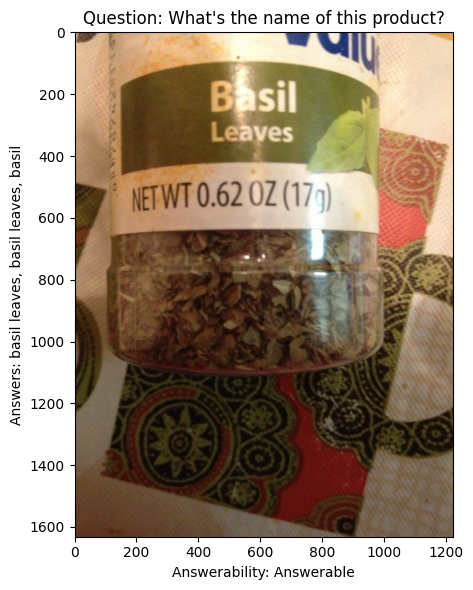

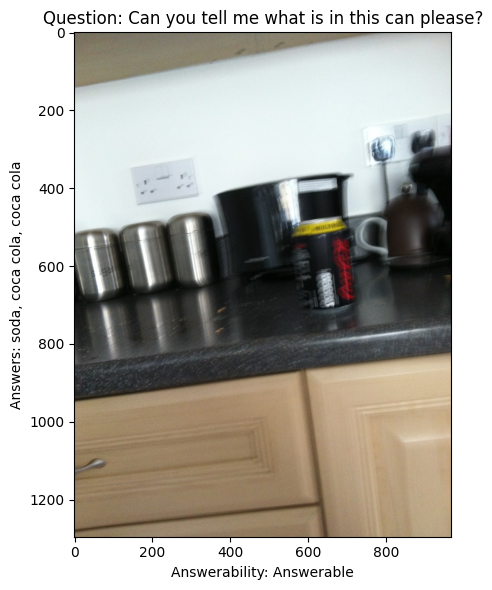

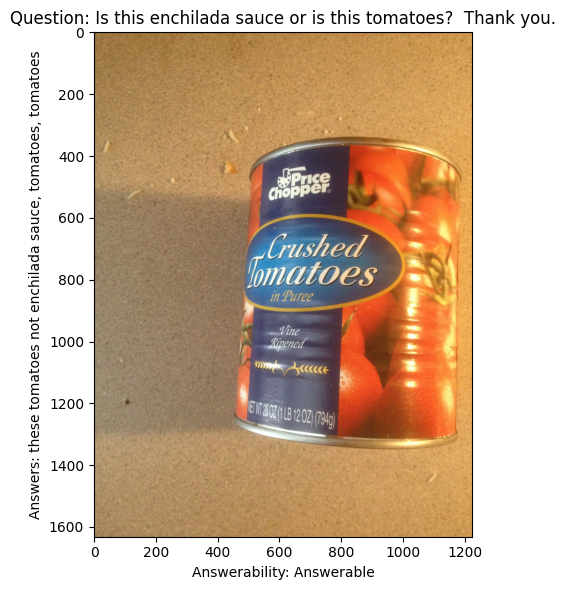

In [ ]:
for i in range(3):
    if i < len(train_data_subset):
        visualize_sample(train_data_subset[i], img_dir)


In [ ]:
class VizWizDataset(Dataset):
    def __init__(self, data, img_dir, tokenizer, is_test=False, max_len=30):
        self.data = data
        self.img_dir = img_dir
        self.tokenizer = tokenizer
        self.is_test = is_test
        self.max_len = max_len


        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
        ])

        # Create answer vocab
        if not is_test:
            self.answer_vocab = self.build_answer_vocab()
            print(f'Answer vocabulary size: {len(self.answer_vocab)}')
            self.idx_to_answer = {v: k for k, v in self.answer_vocab.items()}

    def build_answer_vocab(self):
        ans_vocab = {'<unk>': 0}
        idx = 1

        for sample in self.data:
            if 'answers' in sample:
                processed_ans = process_answers(sample['answers'])
                if processed_ans not in ans_vocab:
                    ans_vocab[processed_ans] = idx
                    idx += 1

        return ans_vocab

    def __len__(self):
        return len(self.data)

    def get_image(self, img_path):
        try:

            response = requests.get(img_path)
            img = Image.open(BytesIO(response.content)).convert('RGB')
            return self.transform(img)
        except Exception as e:
            print(f"Error loading image: {e}")

            return torch.zeros(3, 224, 224)

    def __getitem__(self, idx):
        sample = self.data[idx]

        # BERT tokenizer
        question = sample['question']
        encodings = self.tokenizer(
            question,
            truncation=True,
            max_length=self.max_len,
            padding='max_length',
            return_tensors='pt'
        )


        input_ids = encodings['input_ids'].squeeze(0)
        attention_mask = encodings['attention_mask'].squeeze(0)


        img_path = self.img_dir + sample['image']
        img_tensor = self.get_image(img_path)

        if self.is_test:

            return {
                'image': img_tensor,
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'image_id': sample['image'],
                'question': question
            }
        else:

            answerable = torch.tensor(sample['answerable'], dtype=torch.float)


            processed_ans = process_answers(sample['answers'])
            answer_id = self.answer_vocab.get(processed_ans, 0)  # 0 is <unk>

            return {
                'image': img_tensor,
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'answerable': answerable,
                'answer_id': torch.tensor(answer_id, dtype=torch.long),
                'answer_text': processed_ans,
                'question': question
            }


In [ ]:
print("Creating datasets...")
train_dataset = VizWizDataset(train_data_subset, img_dir, tokenizer)
val_dataset = VizWizDataset(val_data[:1000], img_dir, tokenizer)  # Using a subset of validation data
test_dataset = VizWizDataset(test_data[:100], img_dir, tokenizer, is_test=True)

Creating datasets...
Answer vocabulary size: 879
Answer vocabulary size: 277


In [ ]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
class VQAClassificationModel(nn.Module):
    def __init__(self, hidden_dim=512):
        super(VQAClassificationModel, self).__init__()


        self.img_encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            # Conv block 1
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv block 2
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Final pooling
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.text_embedding = nn.Embedding(tokenizer.vocab_size, 256)
        self.text_encoder = nn.LSTM(256, hidden_dim, batch_first=True, bidirectional=True)

        self.text_attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

        self.fusion = nn.Sequential(
            nn.Linear(256 + hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )

    def forward(self, img, input_ids, attention_mask):
        # Encode image: B x 3 x 224 x 224 -> B x 256 x 1 x 1 -> B x 256
        img_features = self.img_encoder(img).squeeze(-1).squeeze(-1)


        embedded_q = self.text_embedding(input_ids)


        embedded_q = embedded_q * attention_mask.unsqueeze(-1)

        # Process through LSTM
        q_output, _ = self.text_encoder(embedded_q)  # B x seq_len x (hidden_dim*2)

        attention_weights = self.text_attention(q_output).squeeze(-1)  # B x seq_len
        attention_weights = F.softmax(attention_weights.masked_fill((1 - attention_mask).bool(), float('-inf')), dim=1)
        q_features = torch.bmm(attention_weights.unsqueeze(1), q_output).squeeze(1)  # B x (hidden_dim*2)

        combined = torch.cat([img_features, q_features], dim=1)

        # Predict
        output = self.fusion(combined)
        return output.squeeze(-1)


In [ ]:
class VQAAnswerModel(nn.Module):
    def __init__(self, answer_vocab_size, hidden_dim=512):
        super(VQAAnswerModel, self).__init__()

        # Image encoder (more complex CNN for answer prediction)
        self.img_encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            # Conv block 1
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv block 2
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv block 3
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            # Final pooling
            nn.AdaptiveAvgPool2d((1, 1))
        )

        # Question encoder with attention
        self.text_embedding = nn.Embedding(tokenizer.vocab_size, 256)
        self.text_encoder = nn.LSTM(256, hidden_dim, batch_first=True, bidirectional=True, num_layers=2, dropout=0.3)

        # Attention mechanism for text features
        self.text_attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

        # Fusion layers
        self.fusion = nn.Sequential(
            nn.Linear(512 + hidden_dim * 2, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.4)
        )

        # Answer prediction head
        self.classifier = nn.Linear(hidden_dim, answer_vocab_size)

    def forward(self, img, input_ids, attention_mask):
        # Encode image
        img_features = self.img_encoder(img).squeeze(-1).squeeze(-1)  # B x 512

        # Encode question with attention
        embedded_q = self.text_embedding(input_ids)  # B x seq_len x embed_dim

        # Apply mask to zero out padding
        embedded_q = embedded_q * attention_mask.unsqueeze(-1)

        # Process through LSTM
        q_output, _ = self.text_encoder(embedded_q)  # B x seq_len x (hidden_dim*2)

        # Apply attention
        attention_weights = self.text_attention(q_output).squeeze(-1)  # B x seq_len
        attention_weights = F.softmax(attention_weights.masked_fill((1 - attention_mask).bool(), float('-inf')), dim=1)
        q_features = torch.bmm(attention_weights.unsqueeze(1), q_output).squeeze(1)  # B x (hidden_dim*2)

        # Concatenate features and fuse
        combined = torch.cat([img_features, q_features], dim=1)
        fused = self.fusion(combined)

        # Generate answer probabilities
        logits = self.classifier(fused)
        return logits


In [ ]:
def train_classification_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_val_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, batch in enumerate(train_loader):
            # Move data to device
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['answerable'].to(device)

            # Forward pass
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track statistics
            train_loss += loss.item()
            preds = (outputs > 0.5).float()
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

            # Print progress
            if (batch_idx + 1) % 50 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        # Calculate training metrics
        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch in val_loader:
                # Move data to device
                images = batch['image'].to(device)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['answerable'].to(device)

                # Forward pass
                outputs = model(images, input_ids, attention_mask)
                loss = criterion(outputs, labels)

                # Track statistics
                val_loss += loss.item()
                preds = (outputs > 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        # Calculate validation metrics
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = val_correct / val_total

        # Save history
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)

        # Print epoch results
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')

        # Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), 'best_classification_model.pth')
            print(f'Best model saved with validation accuracy: {best_val_acc:.4f}')

    return history

In [ ]:
def train_answer_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_val_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, batch in enumerate(train_loader):
            # Move data to device
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['answer_id'].to(device)

            # Forward pass
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track statistics
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

            # Print progress
            if (batch_idx + 1) % 50 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        # Calculate training metrics
        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch in val_loader:
                # Move data to device
                images = batch['image'].to(device)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['answer_id'].to(device)

                # Forward pass
                outputs = model(images, input_ids, attention_mask)
                loss = criterion(outputs, labels)

                # Track statistics
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        # Calculate validation metrics
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = val_correct / val_total

        # Save history
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)

        # Print epoch results
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')

        # Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), 'best_answer_model.pth')
            print(f'Best model saved with validation accuracy: {best_val_acc:.4f}')

    return history


In [ ]:
def generate_classification_predictions(model, test_loader):
    model.eval()
    all_preds = []

    with torch.no_grad():
        for batch in test_loader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(images, input_ids, attention_mask)
            preds = (outputs > 0.5).int()
            all_preds.extend(preds.cpu().numpy().tolist())

    return torch.tensor(all_preds)

In [ ]:
def generate_answer_predictions(model, test_loader, idx_to_answer):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in test_loader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            image_ids = batch['image_id']

            outputs = model(images, input_ids, attention_mask)
            _, preds = torch.max(outputs, 1)

            for i, pred in enumerate(preds):
                answer_text = idx_to_answer.get(pred.item(), "unknown")
                predictions.append({
                    "image": image_ids[i],
                    "answer": answer_text
                })

    return predictions

In [ ]:
def main():
    # Initialize classification model
    print("Initializing classification model...")
    classification_model = VQAClassificationModel().to(device)
    classification_criterion = nn.BCELoss()
    classification_optimizer = optim.Adam(classification_model.parameters(), lr=0.001)

    # Train classification model
    print("Training classification model...")
    classification_history = train_classification_model(
        classification_model,
        train_loader,
        val_loader,
        classification_criterion,
        classification_optimizer,
        num_epochs=5  # Adjust based on your computational resources
    )

    # Initialize answer prediction model
    print("Initializing answer prediction model...")
    answer_model = VQAAnswerModel(len(train_dataset.answer_vocab)).to(device)
    answer_criterion = nn.CrossEntropyLoss()
    answer_optimizer = optim.Adam(answer_model.parameters(), lr=0.001)

    # Train answer prediction model
    print("Training answer prediction model...")
    answer_history = train_answer_model(
        answer_model,
        train_loader,
        val_loader,
        answer_criterion,
        answer_optimizer,
        num_epochs=5  # Adjust based on your computational resources
    )

    # Generate predictions for Challenge 1
    print("Generating predictions for Challenge 1...")
    classification_model.load_state_dict(torch.load('best_classification_model.pth'))
    cls_predictions = generate_classification_predictions(classification_model, test_loader)
    torch.save(cls_predictions, 'firstname_lastname_challenge1.pkl')
    print("Challenge 1 predictions saved!")

    # Generate predictions for Challenge 2
    print("Generating predictions for Challenge 2...")
    answer_model.load_state_dict(torch.load('best_answer_model.pth'))
    answer_predictions = generate_answer_predictions(answer_model, test_loader, train_dataset.idx_to_answer)
    with open('firstname_lastname_challenge2.json', 'w') as f:
        json.dump(answer_predictions, f)
    print("Challenge 2 predictions saved!")

    # Plot training history
    plot_history(classification_history, "Classification Model")
    plot_history(answer_history, "Answer Prediction Model")

# Plot training history
def plot_history(history, title):
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{title.lower().replace(" ", "_")}_history.png')
    plt.show()

if __name__ == "__main__":
    main()

Initializing classification model...
Training classification model...
Error loading image: [SSL: DECRYPTION_FAILED_OR_BAD_RECORD_MAC] decryption failed or bad record mac (_ssl.c:2580)
Error loading image: [SSL: DECRYPTION_FAILED_OR_BAD_RECORD_MAC] decryption failed or bad record mac (_ssl.c:2580)
Error loading image: [SSL: DECRYPTION_FAILED_OR_BAD_RECORD_MAC] decryption failed or bad record mac (_ssl.c:2580)
Epoch [1/5], Batch [50/63], Loss: 0.5297
Error loading image: [SSL: DECRYPTION_FAILED_OR_BAD_RECORD_MAC] decryption failed or bad record mac (_ssl.c:2580)
Epoch [1/5], Train Loss: 0.5621, Train Acc: 0.7195, Val Loss: 0.6568, Val Acc: 0.5890
Best model saved with validation accuracy: 0.5890
Error loading image: [SSL: DECRYPTION_FAILED_OR_BAD_RECORD_MAC] decryption failed or bad record mac (_ssl.c:2580)
Error loading image: [SSL: DECRYPTION_FAILED_OR_BAD_RECORD_MAC] decryption failed or bad record mac (_ssl.c:2580)
Error loading image: HTTPSConnectionPool(host='vizwiz.cs.colorado.edu